In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import torchvision
import torchvision.transforms as transforms
import time
from collections import OrderedDict
import pandas as pd
from collections import namedtuple
from itertools import product

from torch.utils.tensorboard import SummaryWriter
from IPython.display import display , clear_output
import json
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader
from collections import OrderedDict

torch.set_printoptions(linewidth=150)

In [2]:
train_set  = torchvision.datasets.FashionMNIST(
root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
image,label = train_set[0]

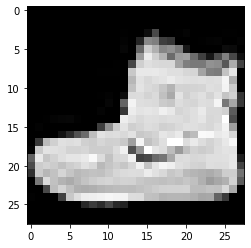

In [4]:
plt.imshow(image.squeeze(),cmap='gray')

In [5]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
image.numel()

784

In [7]:
out_classes = len(train_set.classes)
in_features = image.numel()
in_features

784

In [8]:
out_features = math.floor(in_features/2)
out_features

392

In [9]:
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss  = 0
        self.epoch_num_correct = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
    
    def begin_run(self,run,network,loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader  =loader
        self.tb  = SummaryWriter(comment=f'--{run}')
        
        images,labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images',grid)
        self.tb.add_graph(self.network,images.to(getattr(run,'device','cpu')))
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time  = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy  = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss',loss,self.epoch_count)
        self.tb.add_scalar('Accuracy',accuracy,self.epoch_count)
        
        for name , param in self.network.named_parameters():
            self.tb.add_histogram(name,param,self.epoch_count)
            self.tb.add_histogram(f'{name}.grad',param.grad,self.epoch_count)
            
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data,orient="columns")
        clear_output(wait=True)
        display(df)
        
    def track_loss(self,loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
    
    def track_num_correct(self,preds,labels):
        self.epoch_num_correct = self._get_num_correct(preds,labels)
    
    @torch.no_grad()
    def _get_num_correct(self,preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self,fileName):
        pd.DataFrame.from_dict(self.run_data,orient='columns').to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json','w+',encoding="utf-8") as f:
            json.dump(self.run_data,f,ensure_ascii=False,indent=4)
            
        

In [10]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run',params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

## Methods of creating sequential models

In [11]:
image  = image.unsqueeze(0)
image.shape

torch.Size([1, 1, 28, 28])

In [12]:
torch.manual_seed(50)
#Method 1
network = nn.Sequential(
    nn.Flatten(start_dim=1), #start_dim tells which dimension of the image , the flattening should start from
    nn.Linear(in_features,out_features),
    nn.Linear(out_features,out_classes)
)

#Method 2

layers = OrderedDict([
    ('flat',nn.Flatten(start_dim=1)),
    ('hidden',nn.Linear(in_features,out_features)),
    ('output',nn.Linear(out_features,out_classes))
])

network2 = nn.Sequential(network)

In [13]:
layers = OrderedDict([
    ('flat',nn.Flatten(start_dim=1)),
    ('hidden',nn.Linear(in_features,out_features)),
    ('output',nn.Linear(out_features,out_classes))
])

network = nn.Sequential(network)

In [14]:
network

Sequential(
  (0): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=392, bias=True)
    (2): Linear(in_features=392, out_features=10, bias=True)
  )
)

In [15]:
#Method 3
torch.manual_seed(50)
network3 = nn.Sequential()

network3.add_module('flat',nn.Flatten(start_dim=1))
network3.add_module('hidden',nn.Linear(in_features,out_features))
network3.add_module('output',nn.Linear(out_features,out_classes))

network3

Sequential(
  (flat): Flatten()
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [16]:
network(image),network2(image) , network3(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>))

## Using batchnorm to sequential methods

In [45]:
torch.manual_seed(50)
# network_seq  = nn.Sequential(
#             nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=6 , out_channels=12 , kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Flatten(start_dim=1),
#             nn.Linear(in_features=12*20*20,out_features=120),
#             nn.ReLU(),
#             nn.Linear(in_features=120,out_features=60),
#             nn.ReLU(),
#             nn.Linear(in_features=60,out_features=10)
# )

torch.manual_seed(50)
network_seq_1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Flatten(start_dim=1)  
    , nn.Linear(in_features=12*4*4, out_features=120)
    , nn.ReLU()
    , nn.Linear(in_features=120, out_features=60)
    , nn.ReLU()
    , nn.Linear(in_features=60, out_features=10)
)

In [26]:
torch.manual_seed(50)
network_seq_2  = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(6),
            nn.Conv2d(in_channels=6 , out_channels=12 , kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten(start_dim=1),         
            nn.Linear(in_features=12*4*4,out_features=120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(in_features=120,out_features=60),
            nn.ReLU(),
            nn.Linear(in_features=60,out_features=10)
)

In [27]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
)

In [28]:
loader = DataLoader(train_set_normal,batch_size=len(train_set),num_workers=1)
data = next(iter(loader))
mean , std  =data[0].mean() , data[0].std()

In [29]:
print(mean)
print(std)

tensor(-0.0001)
tensor(1.)


In [30]:
trainsets = {
    'not_normal':train_set,
    'normal':train_set_normal
}

In [48]:
networks={
    'network1':network_seq_1,
    'network2':network_seq_2,
}

In [51]:
#With Run manager
params = OrderedDict(
    lr = [.01],
    batch_size = [1000],
    num_workers = [1],
    device = ['cuda'],
    trainset  = ['not_normal','normal'],
    network = list(networks.keys())
    
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    device = torch.device(run.device)
    network = networks[run.network].to(device)
#     network = network_seq_1.to(device)
    loader = DataLoader(train_set,batch_size=run.batch_size,num_workers=run.num_workers)
    optimizer = optim.Adam(network.parameters(),lr=run.lr)
    m.begin_run(run,network,loader)
    for epoch in range(2):
        m.begin_epoch()
        for batch in loader:
            images = batch[0].to(device)
            labels  = batch[1].to(device)
            preds  = network(images)
            loss =  F.cross_entropy(preds,labels)
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds,labels)
        
        m.end_epoch()
    m.end_run()
m.save('results') 

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset,network
0,1,1,2.422991,0.001800,4.544926,5.704295,0.01,1000,1,cuda,not_normal,network1
1,1,2,2.390420,0.001500,4.581998,10.337294,0.01,1000,1,cuda,not_normal,network1
2,2,1,2.455609,0.001417,4.556000,5.717259,0.01,1000,1,cuda,not_normal,network2
3,2,2,2.387290,0.001733,4.566001,10.362259,0.01,1000,1,cuda,not_normal,network2
4,3,1,2.405594,0.001400,4.550000,5.725577,0.01,1000,1,cuda,normal,network1
5,3,2,2.393465,0.001767,4.577966,10.355577,0.01,1000,1,cuda,normal,network1
6,4,1,2.531287,0.001783,4.592042,5.789041,0.01,1000,1,cuda,normal,network2
7,4,2,2.657983,0.001800,4.578999,10.452041,0.01,1000,1,cuda,normal,network2
